In [1]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

# import warnings
# warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

/home/petenlf1025/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# load in the train and test datasets
train = pd.read_csv('/home/petenlf1025/document/data/Titanic/train.csv')
test = pd.read_csv('/home/petenlf1025/document/data/Titanic/test.csv')

# Store out passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
full_data = [train, test]

# Some features of my own that I have added in
# Give the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature taht tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

# Features engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new freature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4) # 为何不是加到dataset里面
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int) # 将float转化为int
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ''
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping 'Rare'
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map({'female': 0, 'male': 1}).astype(int)
    # Mapping titles
    title_mapping = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Rare': 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
    # Mapping Fare
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    # Mapping Age
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4
    

/home/petenlf1025/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [4]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis=1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis=1)
test = test.drop(drop_elements, axis=1)

In [5]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1.0
1,1,1,0,2,0,3,1,51,1,2,0,3.0
2,1,3,0,1,0,1,0,22,0,1,1,2.0


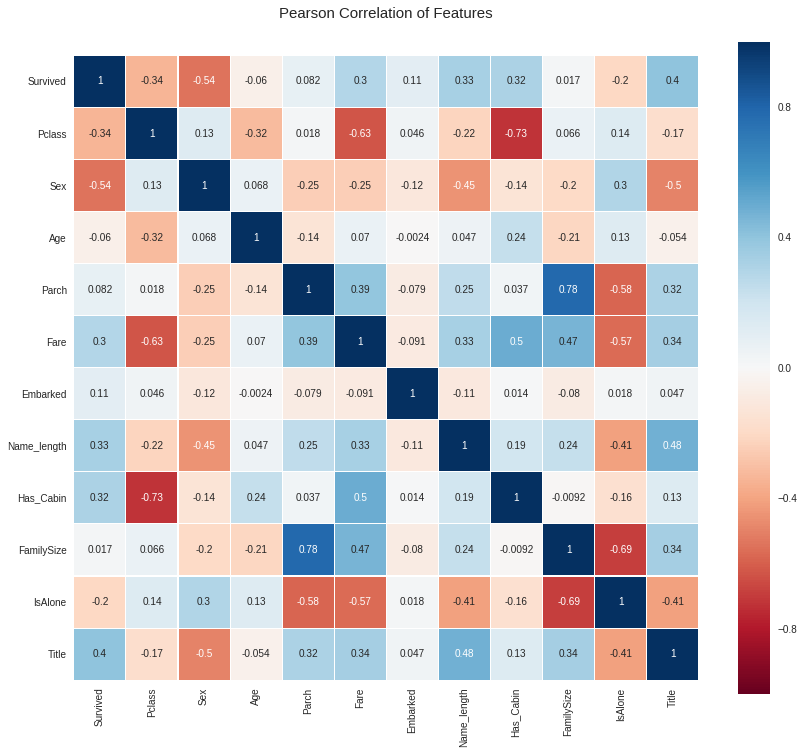

In [6]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

/home/petenlf1025/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning:

invalid value encountered in true_divide

/home/petenlf1025/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning:

invalid value encountered in double_scalars



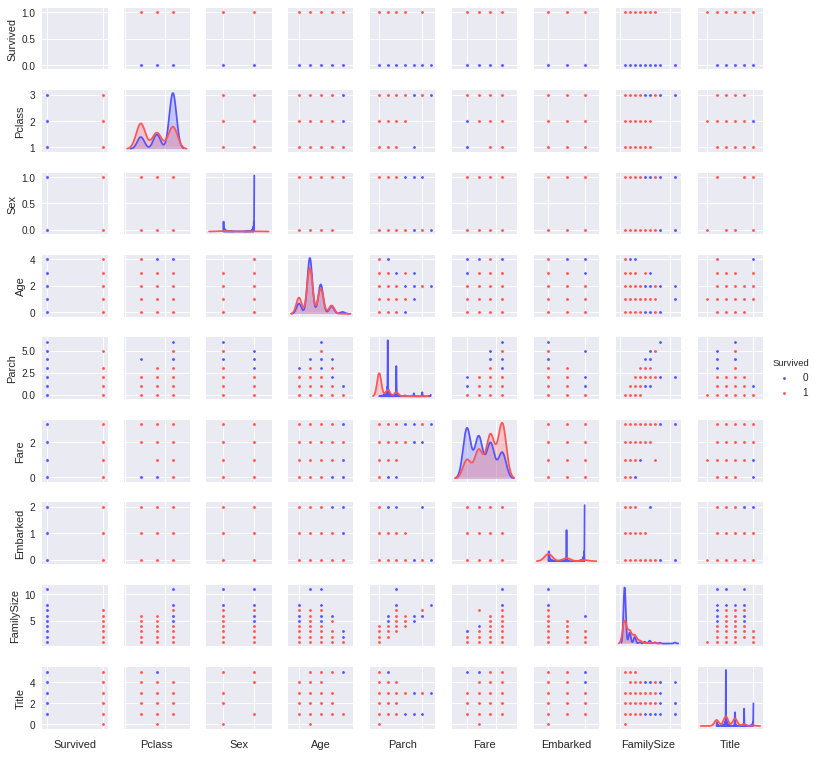

In [7]:
g = sns.pairplot(train[['Survived', 'Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'Title']], 
                 hue='Survived', palette='seismic', size=1.2, diag_kind='kde', 
                 diag_kws=dict(shade=True), plot_kws=dict(s=10))
g.set(xticklabels=[])

In [9]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility 为了可重复性
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds=NFOLDS, random_state=SEED)

In [10]:
# Class to extend the SKlearn classifier
class SklearnHelper():
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
    
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self, x, y):
        return self.clf.fit(x, y)
    
    def feature_importances(self, x, y):
        print(self.clf.fit(x, y).feature_importances_)

# Class to extend XGboost classifer

In [11]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain, ))
    oof_test = np.zeros((ntest, ))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_tr, y_tr)
        
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
        
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

    KFold: k-fold CrossValidation 也就是k-折交叉验证，适用在样本量不足的情况下，为了充分利用数据集对算法效果进行测试，将数据集随机分成training set和test set，进行训练。kf = KFold(ntrain, n_folds=NFOLDS, random_state=SEED)这里将ntrain个原来属于train集合的数据进行交叉验证，检测分类方法在train数据上的效果。clf方法在真实test集合上的预测值实际上是k次不同的数据集训练得到的模型的预测的预测值的平均值。

In [12]:
# Put in our parameters for said classifiers
# Random Forest patameters
rf_params = {
    'n_jobs': -1, 
    'n_estimators': 500, 
    'warm_start': True, 
    #'max_features': 0.2, 
    'max_depth': 6, 
    'min_samples_leaf': 2, 
    'max_features': 'sqrt', 
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1, 
    'n_estimators': 500, 
    #'max_features': 0.5, 
    'max_depth': 8, 
    'min_samples_leaf': 2, 
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500, 
    'learning_rate': 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500, 
    #'max_features': 0.2, 
    'max_depth': 5, 
    'min_samples_leaf': 2, 
    'verbose': 0
}

# Support Vector Classifier parameters
svc_params = {
    'kernel': 'linear', 
    'C': 0.025
}

In [13]:
# Creating 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [14]:
# Creating Numpy arrays of train, test and target (Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creates an array of the test data

In [15]:
import time
start = time.time()
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost
gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test) # Support Vector Classifier

print('Training is complete, costs %ss' % str(time.time() - start))

/home/petenlf1025/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:303: UserWarning:

Warm-start fitting without increasing n_estimators does not fit new trees.



Training is complete, costs 10.61336612701416s


In [16]:
rf_feature = rf.feature_importances(x_train, y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train, y_train)

/home/petenlf1025/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:303: UserWarning:

Warm-start fitting without increasing n_estimators does not fit new trees.



[ 0.12185418  0.20239324  0.03356039  0.02152605  0.07200567  0.02422916
  0.10649934  0.06545849  0.06865727  0.01367562  0.2701406 ]
[ 0.12226474  0.39196918  0.0303749   0.01756441  0.05585611  0.02826484
  0.04702686  0.08518965  0.04366142  0.02151206  0.15631582]
[ 0.032  0.01   0.014  0.066  0.032  0.008  0.7    0.012  0.052  0.     0.074]
[ 0.07702498  0.02830323  0.10509808  0.02904957  0.0952403   0.05200913
  0.41460211  0.02256961  0.06800256  0.02700034  0.0811001 ]


In [17]:
rf_features = [0.12423311, 0.20607438, 0.02930251, 0.02097913, 0.07253235, 0.02537555, 0.10736242, 0.06564794, 0.06717171, 0.0140942, 0.26722671]
et_features = [0.12266142, 0.39012301, 0.02800509, 0.01713554, 0.05727843, 0.02899123, 0.04904673, 0.08361945, 0.04356924, 0.02210758, 0.15746229]
ada_features = [0.026, 0.008, 0.018, 0.06, 0.038, 0.008, 0.71, 0.012, 0.046, 0.006, 0.068]
gb_features = [0.07001257, 0.04185434, 0.10614915, 0.04017431, 0.10019571, 0.04797116, 0.402475, 0.01893351, 0.06807686, 0.02325442, 0.08090296]

In [18]:
cols = train.columns.values
# Create a DataFrame with features
feature_dataframe = pd.DataFrame({
    'features': cols, 
    'Random Forest feature importances': rf_features, 
    'Extra Trees feature importances': et_features, 
    'AdaBoost feature importances': ada_features, 
    'Gradient Boost feature importances': gb_features
    })

In [19]:
# Scatter plot
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values, 
    x = feature_dataframe['features'].values, 
    mode = 'markers', 
    marker = dict(
        sizemode = 'diameter', 
        sizeref = 1, 
        size = 25, 
#         size = feature_dataframe['AdaBoost feature importances'].values, 
#         color = np.random.rand(500), # set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values, 
        colorscale = 'Portland', 
        showscale = True
    ), 
    text = feature_dataframe['features'].values
)
data = [trace]

layout = go.Layout(
    autosize = True, 
    title = 'Random Forest Feature Importance', 
    hovermode = 'closest', 
#     xaxis = dict(
#         title = 'Pop', 
#         ticklen = 5, 
#         zeroline = False, 
#         gridwidth = 2
#     ), 
    yaxis = dict(
        title = 'Feature Importance', 
        ticklen = 5, 
        gridwidth = 2
    ), 
    showlegend = False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter_2017_12_2')

In [20]:
# Scatter plot
trace = go.Scatter(
    y = feature_dataframe['Extra Trees feature importances'].values, 
    x = feature_dataframe['features'].values, 
    mode = 'markers', 
    marker = dict(
        sizemode = 'diameter', 
        sizeref = 1, 
        size = 25, 
#         size = feature_dataframe['AdaBoost feature importances'].values, 
#         color = np.random.rand(500), # set color equal to a variable
        color = feature_dataframe['Extra Trees feature importances'].values, 
        colorscale = 'Portland', 
        showscale = True
    ), 
    text = feature_dataframe['features'].values
)
data = [trace]

layout = go.Layout(
    autosize = True, 
    title = 'Extra Trees Feature Importance', 
    hovermode = 'closest', 
#     xaxis = dict(
#         title = 'Pop', 
#         ticklen = 5, 
#         zeroline = False, 
#         gridwidth = 2
#     ), 
    yaxis = dict(
        title = 'Feature Importance', 
        ticklen = 5, 
        gridwidth = 2
    ), 
    showlegend = False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter_2017_12_2')

In [21]:
# Scatter plot
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values, 
    x = feature_dataframe['features'].values, 
    mode = 'markers', 
    marker = dict(
        sizemode = 'diameter', 
        sizeref = 1, 
        size = 25, 
#         size = feature_dataframe['AdaBoost feature importances'].values, 
#         color = np.random.rand(500), # set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values, 
        colorscale = 'Portland', 
        showscale = True
    ), 
    text = feature_dataframe['features'].values
)
data = [trace]

layout = go.Layout(
    autosize = True, 
    title = 'AdaBoost Feature Importance', 
    hovermode = 'closest', 
#     xaxis = dict(
#         title = 'Pop', 
#         ticklen = 5, 
#         zeroline = False, 
#         gridwidth = 2
#     ), 
    yaxis = dict(
        title = 'Feature Importance', 
        ticklen = 5, 
        gridwidth = 2
    ), 
    showlegend = False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter_2017_12_2')

In [22]:
# Scatter plot
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values, 
    x = feature_dataframe['features'].values, 
    mode = 'markers', 
    marker = dict(
        sizemode = 'diameter', 
        sizeref = 1, 
        size = 25, 
#         size = feature_dataframe['AdaBoost feature importances'].values, 
#         color = np.random.rand(500), # set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values, 
        colorscale = 'Portland', 
        showscale = True
    ), 
    text = feature_dataframe['features'].values
)
data = [trace]

layout = go.Layout(
    autosize = True, 
    title = 'Gradient Boost Feature Importance', 
    hovermode = 'closest', 
#     xaxis = dict(
#         title = 'Pop', 
#         ticklen = 5, 
#         zeroline = False, 
#         gridwidth = 2
#     ), 
    yaxis = dict(
        title = 'Feature Importance', 
        ticklen = 5, 
        gridwidth = 2
    ), 
    showlegend = False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter_2017_12_2')

In [24]:
# Create the new column containing the average of values
feature_dataframe['mean'] = feature_dataframe.mean(axis=1) # axis = 1 computes the mean row-wise
feature_dataframe

,AdaBoost feature importances,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features,mean
0,0.026,0.122661,0.070013,0.124233,Pclass,0.085727
1,0.008,0.390123,0.041854,0.206074,Sex,0.161513
2,0.018,0.028005,0.106149,0.029303,Age,0.045364
3,0.060,0.017136,0.040174,0.020979,Parch,0.034572
4,0.038,0.057278,0.100196,0.072532,Fare,0.067002
5,0.008,0.028991,0.047971,0.025376,Embarked,0.027584
6,0.710,0.049047,0.402475,0.107362,Name_length,0.317221
7,0.012,0.083619,0.018934,0.065648,Has_Cabin,0.045050
8,0.046,0.043569,0.068077,0.067172,FamilySize,0.056204
9,0.006,0.022108,0.023254,0.014094,IsAlone,0.016364


In [25]:
data = go.Bar(
    y = feature_dataframe['mean'].values, 
    x = feature_dataframe['features'].values, 
    width = 0.5, 
    marker = dict(
        color = feature_dataframe['mean'].values, 
        colorscale = 'Portland', 
        showscale = True, 
        reversescale = False
        ), 
    opacity = 0.6
)
layout = go.Layout(
    autosize = True, 
    title = 'Barplots of Mean Feature Importance', 
    hovermode = 'closest', 
    xaxis = dict(
        title = 'Features', 
        ticklen = 5, 
        zeroline = False, 
        gridwidth = 2, 
    ), 
    yaxis = dict(
        title = 'Feature Importance', 
        ticklen = 5, 
        gridwidth = 2
    ), 
    showlegend = False
)
fig = go.Figure(data=[data], layout=layout)
py.iplot(fig, filename='Bar_direct_labels')

In [26]:
base_predictions_train = pd.DataFrame({
    'RandomForest': rf_oof_train.ravel(), 
    'ExtraTrees': et_oof_train.ravel(), 
    'AdaBoost': ada_oof_train.ravel(), 
    'GradientBoost': gb_oof_train.ravel()
})
base_predictions_train.head()

,AdaBoost,ExtraTrees,GradientBoost,RandomForest
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


In [27]:
data = [
    go.Heatmap(
        z = base_predictions_train.astype(float).corr().values, 
        x = base_predictions_train.columns.values, 
        y = base_predictions_train.columns.values,
        colorscale = 'Viridis', 
        showscale = True, 
        reversescale = True
    )
]
py.iplot(data, filename='labelled_heatmap')

In [28]:
x_train = np.concatenate((et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate((et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [29]:
gbm = xgb.XGBClassifier(
#     learning_rate = 0.02, 
    n_estimators = 2000, 
    max_depth = 4, 
    min_child_weight = 2, 
#     gamma = 1, 
    gamma = 0.9, 
    subsample = 0.8, 
    colsample_bytree = 0.8, 
    objective = 'binary:logistic', 
    nthread = -1, 
    scale_pos_weight = 1)
gbm.fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [30]:
predictions

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0,

In [31]:
# Generate Submission File
StackingSubmission = pd.DataFrame({
    'PassengerId': PassengerId, 
    'Survived': predictions
})
StackingSubmission.to_csv('StackingSubmission.csv', index=False)